# Frequencies of "has" and "hath"

This notebook demonstrates using the <ins>SIA API</ins> to analyse the usage of words "has" and "hath" in Shakespear plays over the years.

_@Hugh, some explaination about the purpose of doing this experiment_

Firstly, a number of dependency modules are imported here.

- `requests`: is used for sending requests to the SIA API.
- `matplotlib.pyplot`: we use the Matplotlib to create the chart based on the results from the SIA API.
- `matplotlib.ticker`: is used for setting up the plot ticks.
- `IPython.display`: is used for rendering the results from the SIA API as HTML tables.

In [1]:
import requests
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator
from IPython.display import display, HTML

Next, we set up the API endpoint here. In this example, we use the <ins>Word Frequencies API</ins>.

In [2]:
request_url = "https://sia.ardc-hdcl-sia-iaw.cloud.edu.au/api/v1/word-frequencies"

In order to use the API, an API key is requried to authenticate the requests. The API key must be specified in a custom HTTP header `X-API-KEY` and sent along with every request.

You should use your own API keys for your own notebooks and always keep your keys confidential. Read more about <ins>how to create API keys</ins> in SIA. 

In [3]:
api_key = "255446bcdde7ca9fe776258d09e8411bbb8d1cade2ebd6aba440f80f6817c3fd"

Then, we start to prepare the request data which we can send to the Word Frequencies API. In this example, we are going to use a text set containing 20 Shakespear plays which has been already uploaded in the SIA platform. Instead of passing the actual text contents to the API, we can tell the API to use one of the texts or text sets from SIA by specifying its ID.

The URL of a text/text set page from <ins>SIA Application</ins> indicates the ID of that text/text set. For example:

```
https://sia.ardc-hdcl-sia-iaw.cloud.edu.au/text-sets/86
```

In this case, the ID of the "20 Shakespear plays" text set is `86`.

We will also pass serveral word frequecies options to the Word Frequencies API. These options are:

- `blockMethod`: We set the block method to `0`(By text), which makes each text from the text set as a single segment.
- `showMetadata`: These Shakespear plays from SIA contain associated metadata. We are going to use the `Date of first performance` metadata to dertermin the year of a play. Therefore, we set this option to `true` to ask the API to return the metadata of texts in addition.
- `outputSpecialWords`: As we are only interested in the words "has" and "hath", we tell the API to only return the frequencies of these two words.
- `outputSpecialWordsOption`: We want to calculate the frequencies for all words but only ouput the frequencies of the words "has" and "hath".
- `excludeWords`: We are excluding some common punctuation marks from our analysis.

To view more details about options of Word Frequencies API, read the <ins>API documentation</ins>.

_@Hugh: more explainations about these options may be specified here_

In [4]:
request_data = {
    'textSet': 86,
    'option': {
        'blockMethod' : 0,         #Segment by text
        'showMetadata' : True,
        'outputSpecialWords': ["has","hath"],
        'outputSpecialWordsOption': 0,  # Only show the word frequencies of special words
        'excludeWords': ["[","\\", "]", "_", "`", "!", "\"", "#", "%", "'", "(", ")", "+", ",", "-", "–", ".", "/", ":", ";", "{", "|", "}", "=", "~", "?" ],
    }
}

The SIA API accept JSON as the request data. Here we have constructed a Python dictionary object with the text set identifier and the word frequencies options. Next we are going to put all things together and use the [Requests](https://requests.readthedocs.io/en/latest/) module to send the request to the SIA API.

In [5]:
# Make API request
response = requests.post(request_url, json=request_data, headers={"X-API-KEY": api_key}, timeout=1200)

We have specified the API endpoint, request data we defined earlier and the `X-API-KEY` HTTP header for the API request and received the response. Please note that the API call can take serveral minutes to finish based on the size of the text or text set. Therefore, we have set the request timeout to `1200` seconds.

Before we start unpacking the response data, we want to make sure the API call was successful by checking the HTTP response code. Read the <ins>API documentation</ins> for all error codes.

In [6]:
print(f"{response.status_code} {response.reason}")
assert response.status_code == 200
response_data = response.json()

200 OK


Now, we have the response data ready from Word Frequencies API. We firstly want to have a glance of the proportions of words "has" and "hath" used in each year from a table. We are going to create the tabular data from response data. Read more about the <ins>response data</ins> of Word Frequencies API.

We will have two header rows for the table. The first header row will display the play names, and the second will list the years of the plays. Instead using the word frequency numbers, we will calculate the proportions of words and display them in each column.

In [7]:
table_headers = []
table_rows = []
for block in response_data['blocks']:
    # Add block names as the first header row.
    if len(table_headers) == 0:
        table_headers.append(['Word'])
    table_headers[0].append(block['name'])

    # Add the years as the second header row.
    if len(table_headers) == 1:
        table_headers.append(['Year'])
    table_headers[1].append(block['metadata']['Date of first performance'])

    # Add data rows.
    for i in range(len(block['frequencies'])):
        frequency = block['frequencies'][i]
        # Check whether the row has been created. If not, initialise the row with the word text.
        if i > len(table_rows) - 1:
            table_rows.append([frequency['word']])
        # Calculate the fequency proportion.
        proportion = str(round(frequency['value'] / block['size'] * 100, 4)) + '%'
        # Append the word frequency proportion to its corresponding row.
        table_rows[i].append(proportion)

The next step is to generate the HTML markups based on the tabular data and render it.

In [8]:
# Start with the opening tags of container and table elements.
html = '<div style="overflow-x: auto; margin-top: 40px;"><table border="1">'

# Append table headers.
for table_row in table_headers:
    html += '<tr>'
    for table_cell in table_row:
        html += f'<th style="white-space: nowrap;">{table_cell}</td>'
    html += '</tr>'

# Append HTML for table rows.
for table_row in table_rows:
    html += '<tr>'
    for table_cell in table_row:
        html += f'<td>{table_cell}</td>'
    html += '</tr>'

# Close the table and container elements.
html += '</table></div>'

# Render the HTML.
display(HTML(html))

hath,0.2059%,0.1726%,0.2299%,0.1826%,0.2186%,0.218%,0.1782%,0.2072%,0.1767%,0.3021%,0.2386%,0.2304%,0.3468%,0.1583%,0.32%,0.226%,0.349%,0.1556%,0.1748%,0.1675%
has,0.0081%,0.0883%,0.0%,0.1289%,0.0336%,0.0306%,0.0153%,0.0438%,0.0%,0.1104%,0.0094%,0.0%,0.0187%,0.1385%,0.0%,0.0%,0.0081%,0.0539%,0.0999%,0.1236%


_@Hugh: more insights about the table can be described here_

Next, we will plot the usage of words "has" and "hath" over the years in a line chart. We will firstly aggregate the word frequencies in each year. Each block from the response data will have the `metadata` about the play. We will use the metadata `Date of first performance` to get the years of play.

In [9]:
year_to_has_count = {}
year_to_hath_count = {}
year_to_word_count = {}
for block in response_data['blocks']:
    # Get the year from metadata.
    year = int(block['metadata']['Date of first performance'])
    for i in range(len(block['frequencies'])):
        frequency = block['frequencies'][i]
        if frequency['word'] == 'has':
            # Build up the count of word 'has' of that year.
            year_to_has_count[year] = year_to_has_count.get(year, 0) + frequency['value']
        elif frequency['word'] == 'hath':
            # Build up the count of word 'hath' of that year.
            year_to_hath_count[year] = year_to_hath_count.get(year, 0) + frequency['value']
        # Build up the total word count of that year.
        year_to_word_count[year] = year_to_word_count.get(year, 0) + block['size']    

We have created three dictionaries:

- `year_to_has_count`: contains the frequency of word "has" from each year.
- `year_to_hath_count`: contains the frequency of word "hath" from each year.
- `year_to_word_count`: contains the total number of words from each year.

We then need to sort the years and calculate the proportions of words in each year.

In [10]:
years = sorted(year_to_word_count.keys())
has_proportions = [(year_to_has_count[key] / year_to_word_count[key]) * 100 for key in sorted(year_to_has_count.keys())]
hath_proportions = [(year_to_hath_count[key] / year_to_word_count[key]) * 100 for key in sorted(year_to_hath_count.keys())]

We have created three lists which we can use for the chart:

- `years`: the list of years sorted from the earliest to the latest.
- `has_proportions`: the proportions of word "has" in each year sorted by year.
- `hath_proportions`: the proportions of word "hath" in each year sorted by year.

Now we will use the [Matplotlib](https://matplotlib.org/) library to create a line chart from these.

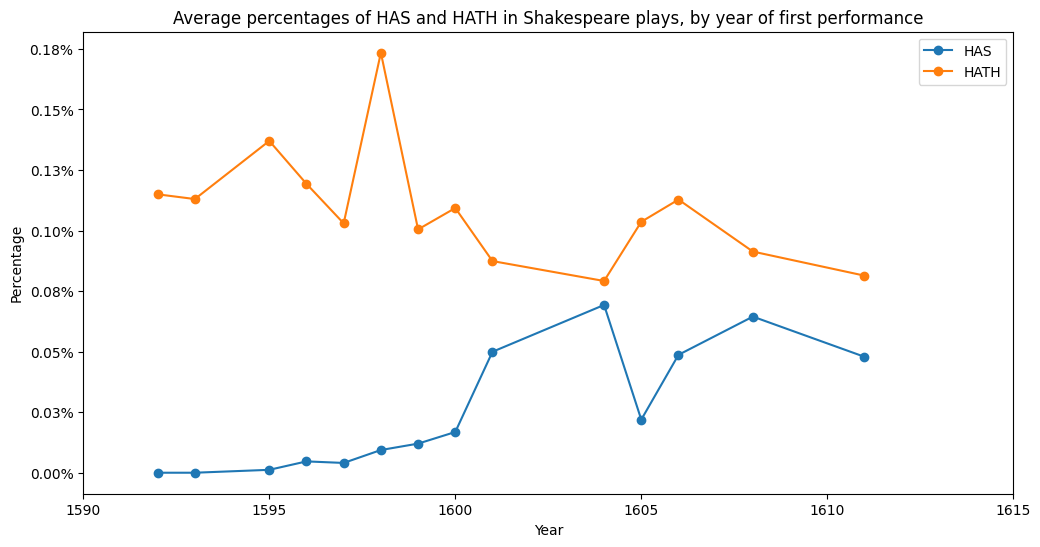

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(years, has_proportions, label='HAS', marker='o')
plt.plot(years, hath_proportions, label='HATH', marker='o')
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Average percentages of HAS and HATH in Shakespeare plays, by year of first performance')

plt.xlim(1590, 1615)
y_ticks = plt.gca().get_yticks()
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))
plt.gca().set_yticklabels(['{:.2f}%'.format(y) for y in y_ticks])

plt.legend()
plt.show()

_@Hugh: some insights about the chart_